<a href="https://colab.research.google.com/github/ozgurumutpirinc/Car-Price-Prediction/blob/main/CAR_PRICE_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Projede kullanacağım kütüphaneleri import ettim

In [39]:
from sklearn.linear_model import LinearRegression, Ridge
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import seaborn as sns

Kullanacağım veri setini projeye ekledim ve özelliklerini görmek için df.info() ve df.head() kullandım

In [2]:
df = pd.read_csv('car_price.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5512 entries, 0 to 5511
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           5512 non-null   int64 
 1   car_name             5512 non-null   object
 2   car_prices_in_rupee  5512 non-null   object
 3   kms_driven           5512 non-null   object
 4   fuel_type            5512 non-null   object
 5   transmission         5512 non-null   object
 6   ownership            5512 non-null   object
 7   manufacture          5512 non-null   int64 
 8   engine               5512 non-null   object
 9   Seats                5512 non-null   object
dtypes: int64(2), object(8)
memory usage: 430.8+ KB


In [3]:
df.head(3)

,Unnamed: 0,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats
0,0,Jeep Compass 2.0 Longitude Option BSIV,10.03 Lakh,"86,226 kms",Diesel,Manual,1st Owner,2017,1956 cc,5 Seats
1,1,Renault Duster RXZ Turbo CVT,12.83 Lakh,"13,248 kms",Petrol,Automatic,1st Owner,2021,1330 cc,5 Seats
2,2,Toyota Camry 2.5 G,16.40 Lakh,"60,343 kms",Petrol,Automatic,1st Owner,2016,2494 cc,5 Seats


Araba fiyatını etkilemeyecek veriler kaldırıldı.

Projenin başında yaptığım en büyük hata, model isimlerinin fiyatı etkilemeyeceğini düşünüp onları veri setinden kaldırmak oldu. Denediğim modellerde düşük skorlar aldığım için bu hatayı sonradan fark edip durumu düzelttim.

In [4]:
df = df.drop(columns = ['Unnamed: 0'])
df.head(3)
le = LabelEncoder()
df['car_name'] = le.fit_transform(df['car_name'])

Araba özelliklerine göre fiyat tahmini yapılacağı için regresyon modelleri kullanılması gerekiyor. Fakat veri setimizde oldukça fazla sayıda kategorik veri var. Sözel verileri dummy ederek regresyon modellerinde kullanmak adına True ve False değerlerine çevirdim.

In [5]:
df = pd.get_dummies(df, columns = ['fuel_type', 'transmission'], drop_first = True)

In [6]:
df.head(3)

,car_name,car_prices_in_rupee,kms_driven,ownership,manufacture,engine,Seats,fuel_type_Diesel,fuel_type_Electric,fuel_type_Lpg,fuel_type_Petrol,transmission_Manual
0,743,10.03 Lakh,"86,226 kms",1st Owner,2017,1956 cc,5 Seats,True,False,False,False,True
1,1444,12.83 Lakh,"13,248 kms",1st Owner,2021,1330 cc,5 Seats,False,False,False,True,False
2,1706,16.40 Lakh,"60,343 kms",1st Owner,2016,2494 cc,5 Seats,False,False,False,True,False


Daha rahat çalışabilmek adına bazı başlıkların isimlerini değiştirdim

In [7]:
df['price'] = df['car_prices_in_rupee']
del df['car_prices_in_rupee']
df['kms'] = df['kms_driven']
del df['kms_driven']

Tahmin edeceğimiz fiyat kısmı 'object' sınıfında yer alıyor. İlk olarak para birimi olan Lakh ve Crore kısımları price sütununda çıkarılarak Currecny adlı yeni bir sütuna atıldı. dropna() ile de eksik veriler temizlendi.

In [8]:
df.loc[df['price'].str.contains('Lakh'), 'Currency'] = 'Lakh'
df.loc[df['price'].str.contains('Crore'), 'Currency'] = 'Crore'
df = df.dropna()

In [9]:
df.head(3)

,car_name,ownership,manufacture,engine,Seats,fuel_type_Diesel,fuel_type_Electric,fuel_type_Lpg,fuel_type_Petrol,transmission_Manual,price,kms,Currency
0,743,1st Owner,2017,1956 cc,5 Seats,True,False,False,False,True,10.03 Lakh,"86,226 kms",Lakh
1,1444,1st Owner,2021,1330 cc,5 Seats,False,False,False,True,False,12.83 Lakh,"13,248 kms",Lakh
2,1706,1st Owner,2016,2494 cc,5 Seats,False,False,False,True,False,16.40 Lakh,"60,343 kms",Lakh


Sayısal verilerin yanındaki sözel ifadeleri aşağıdaki şekilde kaldırdım

In [10]:
df['ownership'] = df['ownership'].str.replace("st Owner", "")
df['ownership'] = df['ownership'].str.replace("nd Owner", "")
df['ownership'] = df['ownership'].str.replace("rd Owner", "")
df['ownership'] = df['ownership'].str.replace("th Owner", "")
df['engine'] = df['engine'].str.replace(" cc", "")
df['Seats'] = df['Seats'].str.replace(" Seats", "")
df['price'] = df['price'].str.replace(" Lakh", "")
df['price'] = df['price'].str.replace(" Crore", "")
df['kms'] = df['kms'].str.replace(" kms", "")

In [11]:
df.head(3)

,car_name,ownership,manufacture,engine,Seats,fuel_type_Diesel,fuel_type_Electric,fuel_type_Lpg,fuel_type_Petrol,transmission_Manual,price,kms,Currency
0,743,1,2017,1956,5,True,False,False,False,True,10.03,"86,226",Lakh
1,1444,1,2021,1330,5,False,False,False,True,False,12.83,"13,248",Lakh
2,1706,1,2016,2494,5,False,False,False,True,False,16.40,"60,343",Lakh


Yukarıda sözel verileri sayısal kısımlardan atmama rağmen veri türü 'object' olarak geçiyordu.

Aslında nümerik veri olan ancak veri setinde kategorik olarak görünen verileri aşağıdaki şekilde nümerik yaptım.

In [12]:
df['ownership'] = pd.to_numeric(df['ownership'])
df['engine'] = pd.to_numeric(df['engine'])
df['Seats'] = pd.to_numeric(df['Seats'])
df['kms'] = df['kms'].str.replace(",", "")
df['kms'] = pd.to_numeric(df['kms'])
df['price'] = df['price'].astype('float')

In [13]:
df.head(3)

,car_name,ownership,manufacture,engine,Seats,fuel_type_Diesel,fuel_type_Electric,fuel_type_Lpg,fuel_type_Petrol,transmission_Manual,price,kms,Currency
0,743,1,2017,1956,5,True,False,False,False,True,10.03,86226,Lakh
1,1444,1,2021,1330,5,False,False,False,True,False,12.83,13248,Lakh
2,1706,1,2016,2494,5,False,False,False,True,False,16.40,60343,Lakh


Fiyatı etkilemeyecek değişken kaldırıldı

In [14]:
df = df.drop('Currency', axis = 1)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5389 entries, 0 to 5511
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   car_name             5389 non-null   int64  
 1   ownership            5389 non-null   int64  
 2   manufacture          5389 non-null   int64  
 3   engine               5389 non-null   int64  
 4   Seats                5389 non-null   int64  
 5   fuel_type_Diesel     5389 non-null   bool   
 6   fuel_type_Electric   5389 non-null   bool   
 7   fuel_type_Lpg        5389 non-null   bool   
 8   fuel_type_Petrol     5389 non-null   bool   
 9   transmission_Manual  5389 non-null   bool   
 10  price                5389 non-null   float64
 11  kms                  5389 non-null   int64  
dtypes: bool(5), float64(1), int64(6)
memory usage: 363.1 KB


Tahmin edilecek değer(y --> araç fiyatı) ve bağımsız       
 değişkenler(x --> y harici her şey) aşağıdaki gibi belirtildi

In [16]:
y = df['price']
x = df.drop('price', axis = 1)

En iyi modeli belirleme amacıyla linear regresyon, random forest regressor ve ridge regresyon, xgbregressor gibi modeller aşağıda cross validation ile train ve test grubuna ayrılarak test edildi

In [17]:
models = [LinearRegression(), xgb.XGBRegressor(), RandomForestRegressor(n_estimators = 1500, max_depth = 50, random_state = 35), Ridge(alpha = 1)]
for model in models:
  score = cross_val_score(model, x, y, cv = 5, scoring = 'r2')
  print(f"skor {model}:{score}")

skor LinearRegression():[0.43460144 0.42342745 0.40277693 0.44912042 0.47706178]
skor XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...):[0.79917505 0.78350938 0.80684729 0.90308989 0.89501059]
skor RandomForestRegressor(max_depth=50, n_estimators=1500, random_state=35):[0.8011549  0.7725693  0.82437842

Cross Validation'a göre en iyi skor veren model yaklaşık olarak 0.90 ile RandomForestRegressor. Bu yüzden onunla devam edeceğiz.

En iyi değerleri elde etmek adına GridCV ile bir hiperparametre optimizasyonu yapıldı. Runtime uzun olabilir.

In [18]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 8, 12],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}


model = RandomForestRegressor()

grid_search = GridSearchCV(model, param_grid, cv=5)


grid_search.fit(x, y)


best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(best_params)
print(best_score)

{'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
0.8377264111085079


Hiperparametre optimizasyonundan sonra elde ettiğimiz en iyi parametreleri aşağıda fit edip skorumuzu alıyoruz

In [19]:
rf = RandomForestRegressor(n_estimators = 100, max_depth = 12, min_samples_leaf = 1, min_samples_split = 2)
rf.fit(x, y)
score = rf.score(x, y)
print(f"skor: {score}")

skor: 0.9741907611731866


In [20]:
df.head(3)

,car_name,ownership,manufacture,engine,Seats,fuel_type_Diesel,fuel_type_Electric,fuel_type_Lpg,fuel_type_Petrol,transmission_Manual,price,kms
0,743,1,2017,1956,5,True,False,False,False,True,10.03,86226
1,1444,1,2021,1330,5,False,False,False,True,False,12.83,13248
2,1706,1,2016,2494,5,False,False,False,True,False,16.40,60343


Aşağıda ilk elemanın özelikleri girilerek bir tahmin yapılmıştır

In [21]:
prediction = [[743, 1, 2017, 1956, 5, 1, 0, 0, 0, 1, 86226]]
rf.predict(prediction)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([9.88477214])

Aşağıdaki data frame'de gerçek değerlerin tahmin edilen değerler ve hata metrikleriyla olan ilişkisi gösterilmiştir.

In [42]:
df_errors = pd.DataFrame()
df_errors['Values'] = y
df_errors['Predictions'] = rf.predict(x)
df_errors['MSE'] = mean_squared_error(y, rf.predict(x))
df_errors['Percentage Error'] = mean_absolute_percentage_error(y, rf.predict(x))
df_errors.head(3)

,Values,Predictions,MSE,Percentage Error
0,10.03,9.884772,4.782557,0.182417
1,12.83,10.121921,4.782557,0.182417
2,16.40,14.954450,4.782557,0.182417


**VERİ GÖRSELLEŞTİRME KISMI**

**1) ENGINE TYPE**

Veri setinde çok farklı sayıda motor tipi(engine) bulunuyor. Ortaya sağlıklı bir grafik çıkarabilmek adına motor tiplerini düşük, orta ve yüksek olmak üzere 3 sınıfa ayırdım. Bu ayırmayı doğru bir şekilde yapmak adına max, min ve ortalama değerlerini göz önünde bulundurdum.

In [24]:
print(np.mean(df['engine']))
print(np.max(df['engine']))
print(np.min(df['engine']))

1534.5832250881426
5950
0


In [25]:
low = 0   # 0-1500
medium = 0  #1500-3000
high = 0  #+3000

for i in df['engine']:
  if i >= 3500:
    high += 1
  elif i >= 1500 and i < 3500:
    medium += 1
  else:
    low += 1


([<matplotlib.patches.Wedge at 0x794a26567250>,
 [Text(-0.5744340537615705, 0.9380967529413208, '0-1499 cc'),
  Text(0.5512954129444378, -0.9518788618655328, '1500-2999 cc'),
  Text(1.0996703001098354, -0.026930114302485268, '+3000 cc')],
 [Text(-0.3133276656881293, 0.5116891379679931, '67.5%'),
  Text(0.3007065888787842, -0.5192066519266542, '31.7%'),
  Text(0.5998201636962738, -0.014689153255901054, '0.8%')])

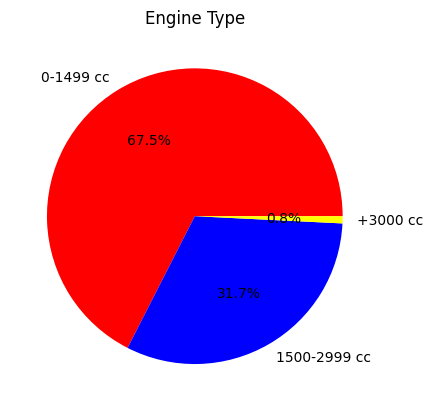

In [26]:
sizes = [low, medium, high]
plt.title('Engine Type')
plt.pie(sizes, labels = ['0-1499 cc', '1500-2999 cc', '+3000 cc'], colors = ['red', 'blue', 'yellow'], autopct='%1.1f%%')

Engine Types grafiği, piyasada daha çok 0-1499 cc arasındaki motor gücüne sahip arabaların olduğunu gösteriyor.

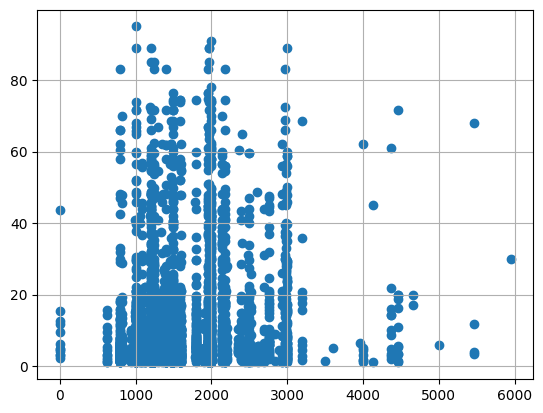

In [27]:
plt.scatter(df['engine'], df['price'])
plt.grid(True)
plt.show()

Yukarıdaki grafik, görüntü olarak şık olmasa da motor tipiyle araba fiyatı ilişkisini gösteriyor. Grafiğe göre, 'medium' olarak ayırdığımız motor tipi sınıfı diğer sınıflara oranla daha yüksek fiyata sahip.

**2) SEATS**

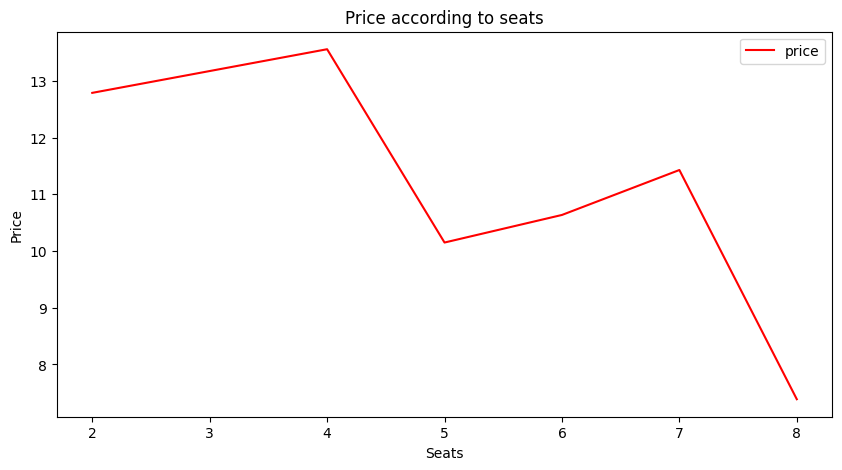

In [28]:
pv_seats = pd.pivot_table(df, index = ['Seats'], values = ['price'], aggfunc = 'mean')
pv_seats.plot(kind = 'line', figsize = (10, 5), color = 'red', title = 'Price according to seats')
plt.xlabel('Seats')
plt.ylabel('Price')
plt.show()

Koltuk sayısına göre araba fiyatı grafiği aslında pek bir anlam ifade etmemektedir.

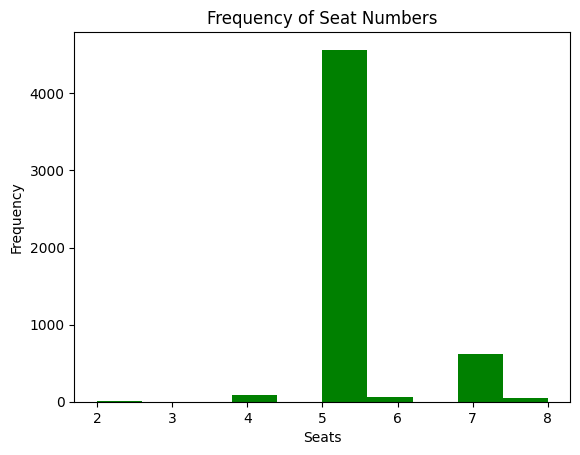

In [29]:
plt.hist(df['Seats'], color = 'green')
plt.title('Frequency of Seat Numbers')
plt.xlabel('Seats')
plt.ylabel('Frequency')
plt.show()

Arabaların koltuk sayısına göre sınıflandırıldığı grafikte piyasada 5 koltuklu arabaların daha sık bulunduğunu anlıyoruz.

**3) OWNERSHIP**

Text(0, 0.5, 'Price')

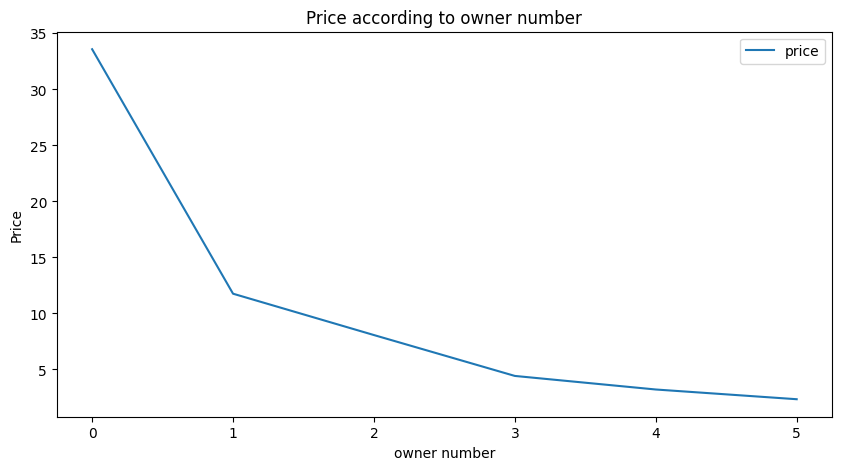

In [30]:
pv_owner = pd.pivot_table(df, index = ['ownership'], values = ['price'], aggfunc = 'mean')
pv_owner.plot(kind = 'line', figsize = (10, 5), title = 'Price according to owner number')
plt.xlabel('owner number')
plt.ylabel('Price')

pivot tablo yardımıyla yukarıdaki tablo çizilmiştir. Her bir sahip numarası için fiyatın ortalaması alınmıştır.
Grafiğe göre araba el değiştirdikçe fiyatı azalmaktadır.

**4) TRANSMISSION**

Elimizde Manuel ve Otomatik olmak üzere iki farklı vites türü var. Aşağıdaki kod bloğu ile bunların sayıları tespit edilip yüzdelikleri pasta grafiğinde gösterilmiştir.

([<matplotlib.patches.Wedge at 0x794a2617d5a0>,
 [Text(-0.6811732747418542, 0.8637146344583139, 'Manual'),
  Text(0.6811732747418541, -0.863714634458314, 'Automatic')],
 [Text(-0.3715490589501022, 0.47111707334089836, '71.3%'),
  Text(0.37154905895010215, -0.4711170733408985, '28.7%')])

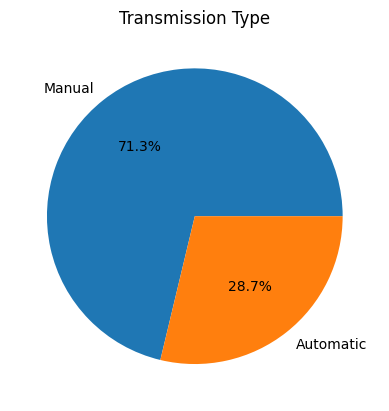

In [31]:
manual = df['transmission_Manual'].sum()
automatic = len(df['transmission_Manual']) - manual
sizes = [manual, automatic]
plt.title('Transmission Type')
plt.pie(sizes, labels = ['Manual', 'Automatic'], autopct='%1.1f%%')

**5) FUEL TYPE**

Elektrik ve LPG sınıfı araçların sayısı çok az olduğu için grafikte kötü bir görüntü oluşuyordu. O yüzden ikisini bir alarak grafiği oluşturdum.

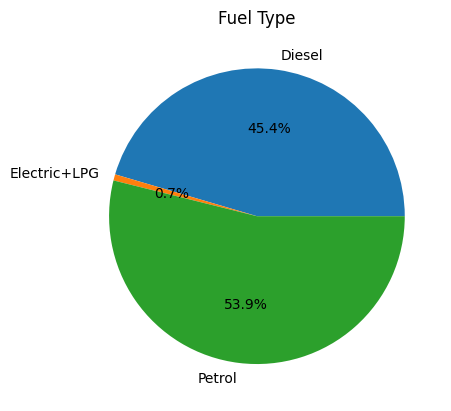

In [32]:
diesel = df['fuel_type_Diesel'].sum()
petrol = df['fuel_type_Petrol'].sum()
electric = df['fuel_type_Electric'].sum()
lpg = df['fuel_type_Lpg'].sum()

sizes = [diesel, electric+lpg, petrol]
plt.title('Fuel Type')
plt.pie(sizes, labels = ['Diesel', 'Electric+LPG', 'Petrol'], autopct='%1.1f%%')
plt.show()

Grafikten anlaşılacağı üzere en çok benzinli araç kullanılırken elektrikli ve LPG'li araçların sayısı çok çok azdır.

**6) KMS**

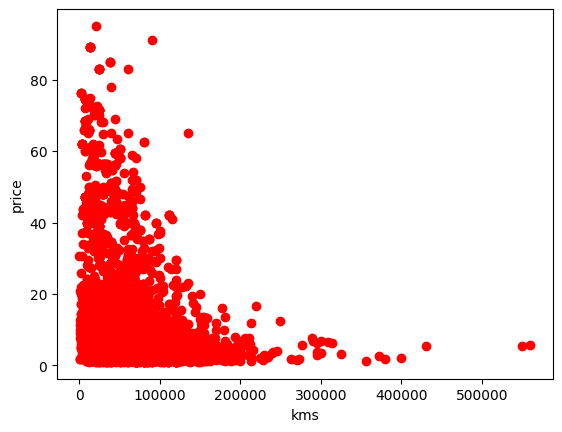

In [34]:
plt.scatter(df['kms'], df['price'], c = 'red')
plt.xlabel('kms')
plt.ylabel('price')
plt.show()

Kilometresi az olan araçların fiyatları daha yüsektir. Arabanın yaptığı km arttıkça fiyatı azalmaktadır. Sağ-eğik(Right-Skewed) bir grafiktir.

**7) MANUFACTURE**

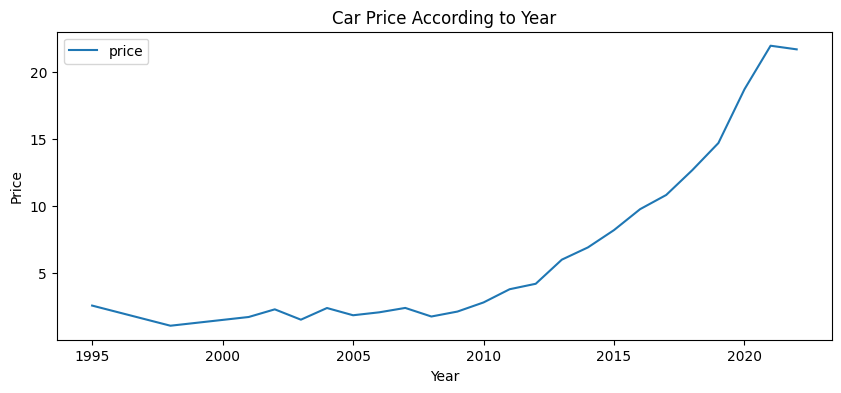

In [33]:
pv_year = pd.pivot_table(df, index = ['manufacture'], values = ['price'],  aggfunc = 'mean')
pv_year.plot(kind = 'line', figsize = (10, 4))
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Car Price According to Year')
plt.show()

Üretim yılına göre araç fiyatları eğrisi, yeni üretilen arabaların daha yüksek fiyatta alıcı bulduğunu, bir diğer deyişle arabanın eskidikçe fiyatının azaldığını gözlemleyebiliriz.